# Combining satellite data with tidal modelling <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background

Ocean tides are the periodic rise and fall of the ocean caused by the gravitational pull of the moon and sun and the earth's rotation. 
Tides in coastal areas can greatly influence how these environments appear in satellite imagery as water levels vary by up to 12 metres (e.g. in north-western Australia).
To be able to study coastal environments and processes along Australia's coastline, it is vital to obtain data on tidal conditions at the exact moment each satellite image was acquired.

## Description
This notebook demonstrates how to combine remotely sensed imagery with information about ocean tides using functions from the [`dea_tools.coastal` module](../Tools/dea_tools/coastal.py), allowing us to analyse satellite imagery by tidal stage (e.g. low, high, ebb, flow). 
These functions use the [Finite Element Solution 2014 (FES2014) tidal model](https://os.copernicus.org/articles/17/615/2021/) to calculate the height (relative to mean sea level, i.e. approximately equivalent to the Australian Height Datum or AHD) and stage of the tide at the exact moment each satellite image was acquired. 

These tide modelling tools and tide models underpin DEA datasets including [DEA Coastlines](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines#basics), [DEA Intertidal Extents (ITEM)](http://dx.doi.org/10.4225/25/5a602cc9eb358), [DEA High Low Tide Imagery (HLTC)](http://dx.doi.org/10.4225/25/5a615705d20f7), and [DEA Intertidal Elevation (NIDEM)](http://dx.doi.org/10.26186/5c4fc06a79f76).

The notebook demonstrates how to:

1. Model tide heights for specific coordinates and times using the `model_tides` function
2. Model tide heights for each satellite observation using the `tidal_tag` function
3. Use tide height data to produce median composites of the coast at low and high tide
4. Swap a dataset's dimensions to make it easier to select imagery from low to high tide.
5. Compute ebb or flow tide phase data to determine whether water levels were rising or falling in each satellite observation

Advanced tools:

6. Spatially model tides into each pixel of a satellite dataset using `pixel_tides`
7. Evaluate potential biases in the tidal conditions observed by a satellite using the `tidal_stats` function

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
import datacube
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats


### Connect to the datacube


In [2]:
dc = datacube.Datacube(app='Tidal_modelling')


## Modelling tides for specific coordinates and times
To simply model tide heights for a specific location and set of times, we can use the `dea_tools.coastal.model_tides` function. 
For example, we can model hourly tides across a one month period (September 2022):

In [3]:
# Set of times to model tides for
date_list = pd.date_range(start="2022-09-01", end="2022-09-30", freq="1H")

# Run the FES2014 tidal model
tide_df = model_tides(
    x=[122.21],
    y=[-18.20],
    time=date_list,
)

# Print outputs
tide_df.head()


,x,y,tide_m
time,,,
2022-09-01 00:00:00,122.21,-18.2,-3.606787
2022-09-01 01:00:00,122.21,-18.2,-2.470167
2022-09-01 02:00:00,122.21,-18.2,-0.675034
2022-09-01 03:00:00,122.21,-18.2,1.140802
2022-09-01 04:00:00,122.21,-18.2,2.591887


Tide heights for each time and coordinate are included in the `tide_m` column above  (representing tide height in metres relative to Mean Sea Level).

We can also plot out resulting tides to view how tides changed across this month. 
By looking at the y-axis, we can see that tides ranged from a minimum of ~-4 metres up to a maximum of +4 metres relative to Mean Sea Level:

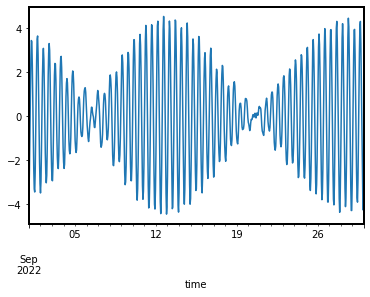

In [4]:
tide_df.tide_m.plot();

## Modelling tide heights for each satellite observation

However, often it is valuable to estimate the height of the tide at the exact moment satellite images were taken over a coastline.
This can help sort and filter images by tide height, allowing us to learn more about how coastal environments respond to the effect of changing tides.

To demonstrate how this can be done, we first need to load in an example time series of satellite imagery.

### Set up data query

First we set up a query to define the area, time period and other parameters required for loading data.
In this example, we will load several years of Landsat 8 data for intertidal mud flats **south of Broome in Western Australia**.
We load the `'nbart_red', 'nbart_green', 'nbart_blue'` bands so that we can plot the data as true colour imagery.

> The `dask_chunks` parameter allows us to [use Dask](https://examples.dask.org/xarray.html) to lazily load data rather than load data directly into memory, which can take a long time and large amounts of memory.
Lazy loading can be a very useful approach for when you need to load large amounts of data without crashing your analysis.
In coastal applications, it allows us to load (using either `.compute()` or by plotting our data) only a small subset of observations from our entire time series (e.g. only low or high tide observations) without having to load the entire dataset into memory first, which can greatly decrease processing times.
>
> For more information about using Dask, refer to the [Parallel processing with Dask](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb) notebook.

In [5]:
# Set up data load query
query = {
    'x': (122.15, 122.28),
    'y': (-18.14, -18.26),
    'time': ('2019', '2021'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'output_crs': 'EPSG:32755',
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {},
}

We can preview the area that we will load data for:

In [6]:
display_map(x=query['x'], y=query['y'])

### Load satellite time-series

To obtain some satellite data to analyse, we use the `load_ard` function to import a time series of Landsat 8 observations as an `xarray.Dataset`.
The input data does not need to be from Landsat: any remotely-sensed imagery with timestamps and spatial coordinates provide enough data to run the tidal model. 

In [7]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls8c_ard_3'],
              ls7_slc_off=False,
              **query)

# Print output data
ds

Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 136 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 136, y: 550, x: 564)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T01:55:10.045362 ... 2021-12...
  * y            (y) float64 7.806e+06 7.806e+06 ... 7.789e+06 7.789e+06
  * x            (x) float64 -2.197e+06 -2.197e+06 ... -2.181e+06 -2.181e+06
    spatial_ref  int32 32755
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

### "Tagging" each satellite image with tide height metadata

We can now use the `tidal_tag` function from `dea_coastaltools` to "tag" or associate each satellite observation in our time series with a tide height relative to mean sea level (i.e. approximately equivalent to the Australian Height Datum or AHD).
This function uses the time and date of acquisition and the geographic location of each satellite observation as inputs to the [Finite Element Solution 2014 (FES2014) tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html):

> **FES2014** is the last version of the FES (Finite Element Solution) tide model developed in 2014-2016. It is an improved version of the FES2012 model. This new FES2014 model has been developed, implemented and validated by the LEGOS, NOVELTIS and CLS, within a CNES funded project. FES2014 takes advantage of longer altimeter time series and better altimeter standards, improved modelling and data assimilation techniques, a more accurate ocean bathymetry and a refined mesh in most of the shallow water regions. Special efforts have been dedicated to address the major non-linear tides issue and to the determination of accurate tidal currents.

The function will automatically select a tide modelling location based on the dataset centroid.
It will then output modelled tide heights as a new `tide_m` variable in the `xarray.Dataset` (the variable should appear under `Data variables` below):

In [8]:
# Model tide heights
ds_tidal = tidal_tag(ds)

# Print output data
ds_tidal


Setting tide modelling location from dataset centroid: 122.21, -18.20
Modelling tides using FES2014 tidal model


<xarray.Dataset>
Dimensions:      (time: 136, y: 550, x: 564)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T01:55:10.045362 ... 2021-12...
  * y            (y) float64 7.806e+06 7.806e+06 ... 7.789e+06 7.789e+06
  * x            (x) float64 -2.197e+06 -2.197e+06 ... -2.181e+06 -2.181e+06
    spatial_ref  int32 32755
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    tide_m       (time) float64 -0.3249 -0.6027 -0.2904 ... 2.083 -0.9091
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

We can easily plot this new variable to inspect the range of tide heights observed by the satellites in our time series.
In this example, our observed tide heights range from approximately -2.0 to 4.0 m relative to Mean Sea Level:

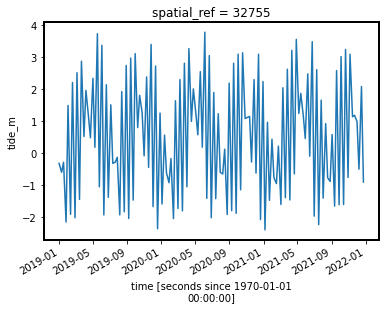

In [9]:
ds_tidal.tide_m.plot();

### Example tide height analysis
To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
imagery, we can compute the lowest 10% and highest 10% of tide heights, and use these to filter our observations. 
We can then combine and plot these filtered observations to visualise how the landscape appears at low and high tide:

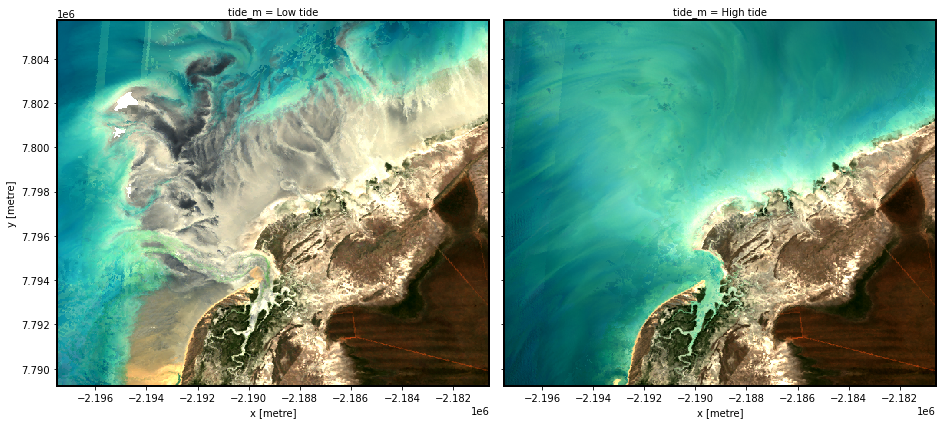

In [10]:
# Calculate the lowest and highest 10% of tides
lowest_10, highest_10 = ds_tidal.tide_m.quantile([0.1, 0.9]).values

# Filter our data to low and high tide observations
filtered_low = ds_tidal.where(ds_tidal.tide_m <= lowest_10, drop=True)
filtered_high = ds_tidal.where(ds_tidal.tide_m >= highest_10, drop=True)

# Take the simple median of each set of low and high tide observations to 
# produce a composite (alternatively, observations could be combined 
# using a geomedian to keep band relationships consistent)
median_low = filtered_low.median(dim='time', keep_attrs=True)
median_high = filtered_high.median(dim='time', keep_attrs=True)

# Combine low and high tide medians into a single dataset and give 
# each layer a meaningful name
ds_highlow = xr.concat([median_low, median_high], dim='tide_m')
ds_highlow['tide_m'] = ['Low tide', 'High tide']

# Plot low and high tide medians side-by-side
rgb(ds_highlow, col='tide_m')


### Swapping dimensions

The `tidal_tag` function allows you to use tide heights as the primary dimension in the dataset, rather than time.
Setting `swap_dims=True` will swap the `time` dimension in the original `xarray.Dataset` to the new `tide_m` variable.

In [11]:
# Model tide heights
ds_tidal = tidal_tag(ds, swap_dims=True)

# Print output data
ds_tidal

Setting tide modelling location from dataset centroid: 122.21, -18.20
Modelling tides using FES2014 tidal model


<xarray.Dataset>
Dimensions:      (tide_m: 136, y: 550, x: 564)
Coordinates:
  * y            (y) float64 7.806e+06 7.806e+06 ... 7.789e+06 7.789e+06
  * x            (x) float64 -2.197e+06 -2.197e+06 ... -2.181e+06 -2.181e+06
    spatial_ref  int32 32755
  * tide_m       (tide_m) float64 -2.407 -2.372 -2.244 ... 3.562 3.739 3.787
Data variables:
    nbart_red    (tide_m, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_green  (tide_m, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_blue   (tide_m, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

The dataset now contains three dimensions: `tide_m`, `x` and `y`. 
This can make it easier to analyse the data with respect to tide, e.g. plotting a sequence of images by tide height:

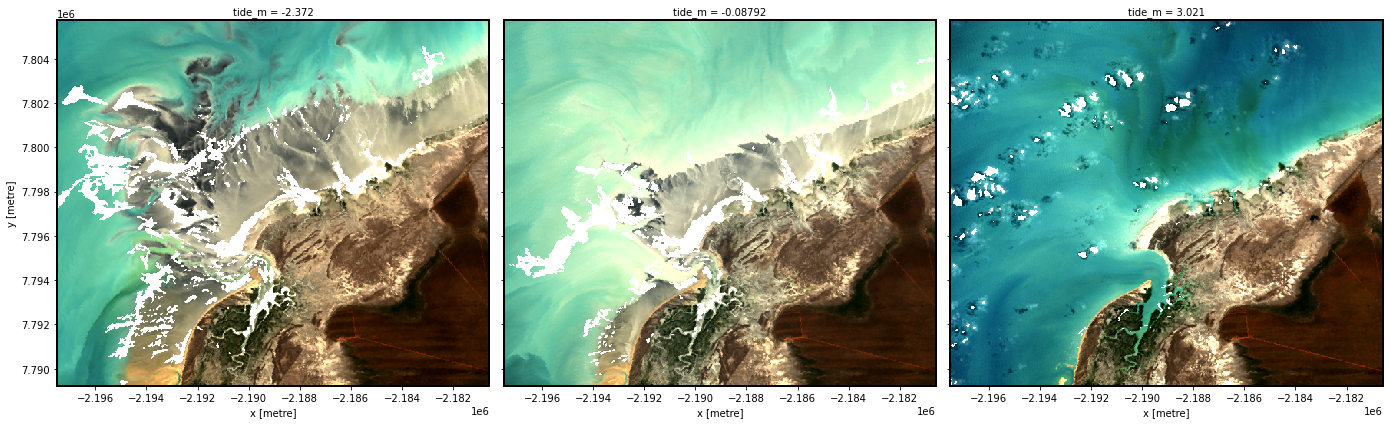

In [12]:
# Plot images by increasing tide height
rgb(ds_tidal, index_dim='tide_m', index=[1, 60, 120])

## Modelling ebb and flow tidal phases

The `tidal_tag` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`.
This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

In [13]:
# Model tide heights
ds_tidal = tidal_tag(ds, ebb_flow=True)

# Print output data
ds_tidal

Setting tide modelling location from dataset centroid: 122.21, -18.20
Modelling tides using FES2014 tidal model
Modelling tidal phase (e.g. ebb or flow)


<xarray.Dataset>
Dimensions:      (time: 136, y: 550, x: 564)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T01:55:10.045362 ... 2021-12...
  * y            (y) float64 7.806e+06 7.806e+06 ... 7.789e+06 7.789e+06
  * x            (x) float64 -2.197e+06 -2.197e+06 ... -2.181e+06 -2.181e+06
    spatial_ref  int32 32755
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    tide_m       (time) float64 -0.3249 -0.6027 -0.2904 ... 2.083 -0.9091
    ebb_flow     (time) <U4 'Ebb' 'Flow' 'Ebb' 'Flow' ... 'Flow' 'Ebb' 'Flow'
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

We now have data giving us the both the tide height and tidal phase ('ebb' or 'flow') for every satellite image:

In [14]:
ds_tidal[['time', 'tide_m', 'ebb_flow']].to_dataframe().drop('spatial_ref',
                                                             axis=1)

,tide_m,ebb_flow
time,,
2019-01-01 01:55:10.045362,-0.324911,Ebb
2019-01-10 01:49:22.019554,-0.602660,Flow
2019-01-17 01:55:07.420345,-0.290403,Ebb
2019-01-26 01:49:18.114348,-2.161653,Flow
2019-02-02 01:55:03.684910,1.490913,Flow
...,...,...
2021-11-22 01:55:38.241313,1.183009,Flow
2021-12-01 01:49:52.530438,0.991971,Ebb
2021-12-08 01:55:39.297251,-0.505351,Flow


We could for example use this data to filter our observations to keep ebbing phase observations only:

In [15]:
ds_tidal.where(ds_tidal.ebb_flow == 'Ebb', drop=True)

<xarray.Dataset>
Dimensions:      (time: 43, y: 550, x: 564)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T01:55:10.045362 ... 2021-12...
  * y            (y) float64 7.806e+06 7.806e+06 ... 7.789e+06 7.789e+06
  * x            (x) float64 -2.197e+06 -2.197e+06 ... -2.181e+06 -2.181e+06
    spatial_ref  int32 32755
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    tide_m       (time) float64 -0.3249 -0.2904 0.5182 ... 1.136 0.992 2.083
    ebb_flow     (time) object 'Ebb' 'Ebb' 'Ebb' 'Ebb' ... 'Ebb' 'Ebb' 'Ebb'
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

## Advanced

### Modelling tides for each pixel in a satellite time series

The previous examples show how to model a single tide height for each satellite image using the centroid of the image as a tide modelling location. 
However, in reality tides vary spatially, potentially up to several metres across a distance of kilometres in areas of complex tidal dynamics. 
This means that an individual satellite image can contain a range of tide height conditions.

To capture this spatial variability in tide heights, we can use the `pixel_tides` function from `dea_tools.coastal`.
For efficient processing, this function first models tides into a low resolution 5000 m grid surrounding each satellite image in our time series.
This lower resolution data will also include a buffer around the extent of our data tides can be modelled seamlessly across analysis boundaries:

In [16]:
# Extract a subset of our satellite data above to make plotting easier
ds_subset = ds.isel(time=slice(1, 6))

# Model tides spatially using `pixel_tides`
tides_lowres = pixel_tides(ds_subset, resample=False)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Returning low resolution tide array


If we plot the resulting data, we can see that we now have 2D tide surfaces for each timestep in our data (instead of the single tide height per timestamp returned by the `tidal_tag` function).

Blue values below indicate low tide pixels, while red indicates high tide pixels.
If you look closely at the third and fifth timestep below, you may also be able to see some spatial variability in tide heights within each timestep, with slightly higher tides in the north-west of the images:

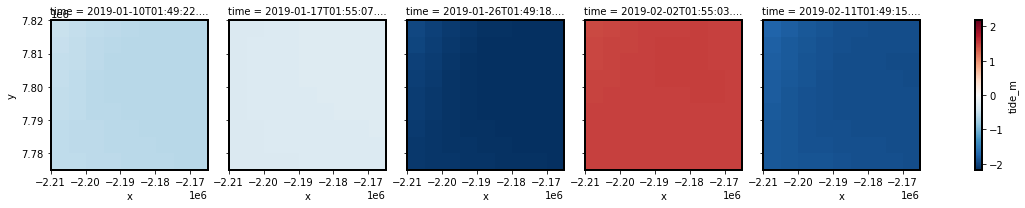

In [17]:
tides_lowres.plot.imshow(col='time')

#### Reprojecting tide heights back into original high resolution spatial grid
By setting `resample=True`, we can use interpolation to re-project our low resolution tide data back into the resolution of our satellite image, resulting in an individual tide height value for every single pixel in our dataset through time and space:

In [18]:
tides_highres, tides_lowres = pixel_tides(ds_subset, resample=True)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 5/5 [00:00<00:00, 58.33it/s]


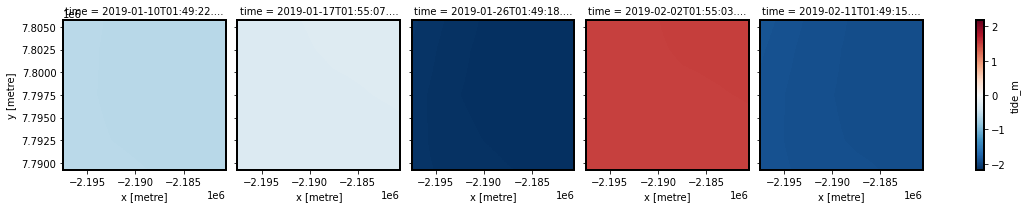

In [19]:
tides_highres.plot.imshow(col='time')

`tides_highres` will have exactly the same dimensions as `ds_subset`, with a unique tide height for every satellite pixel:

In [20]:
ds_subset.sizes

Frozen({'time': 5, 'y': 550, 'x': 564})

In [21]:
tides_highres.sizes

Frozen({'time': 5, 'y': 550, 'x': 564})

Because of this, our stack of tides can be added as an additional 3D variable in our dataset:

In [22]:
ds_subset['tide_m'] = tides_highres
ds_subset

<xarray.Dataset>
Dimensions:      (time: 5, y: 550, x: 564)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-10T01:49:22.019554 ... 2019-02...
  * y            (y) float64 7.806e+06 7.806e+06 ... 7.789e+06 7.789e+06
  * x            (x) float64 -2.197e+06 -2.197e+06 ... -2.181e+06 -2.181e+06
    spatial_ref  int32 32755
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 550, 564), meta=np.ndarray>
    tide_m       (time, y, x) float32 -0.5751 -0.5753 -0.5754 ... -1.923 -1.923
    ebb_flow     (time) <U4 'Flow' 'Ebb' 'Flow' 'Flow' 'Flow'
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

#### Calculating min/max/median/quantiles of tide heights for each pixel

Min, max or any specific quantile of all tide heights observed over a region can be calculated for each pixel by passing in a list of quantiles/percentiles. 

This calculation is performed on the low resolution modelled tide data before reprojecting to higher resolution, so should be faster than calculating min/max/median tide at high resolution:

In [23]:
tides_highres_quantiles, tides_lowres_quantiles = pixel_tides(
    ds_subset, resample=True, calculate_quantiles=(0, 0.5, 1))

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 3/3 [00:00<00:00, 37.53it/s]


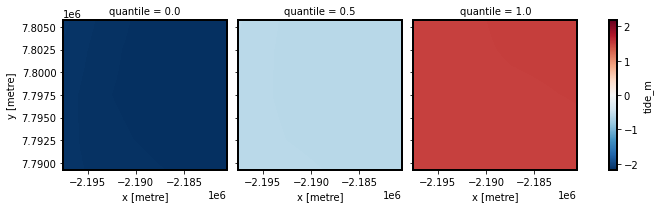

In [24]:
tides_highres_quantiles.plot.imshow(col='quantile')

#### Pixel-based tides for custom times
Instead of using times contained in the `time` dimension of our dataset, we can also calculate pixel-based tides for a custom set of times:

In [25]:
custom_times = pd.date_range(start="2022-01-01", end="2022-01-02", freq="6H")

tides_highres, tides_lowres = pixel_tides(ds_subset,
                                          resample=True,
                                          times=custom_times)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 5/5 [00:00<00:00, 57.96it/s]


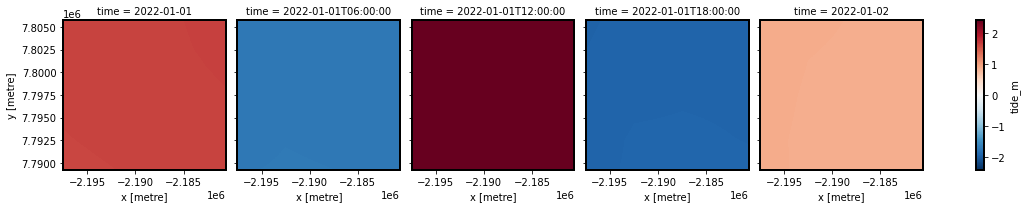

In [26]:
tides_highres.plot.imshow(col='time')

### Evaluating satellite-observed vs. all available tide heights

The complex temporal behaviour of tides mean that a sun synchronous sensor like Landsat [does not observe the full range of the tidal cycle at all locations](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).
Biases in the proportion of the tidal range observed by satellites can prevent us from obtaining data on areas of the coastline exposed or inundated at the extremes of the
tidal range. 
This can risk gaining misleading insights into the true extent of the area of the coastline affected by tides, and make it difficult to compare high or low tide images fairly in different locations.

The `tidal_stats` function can assist in evaluating how the range of tides observed by satellites compare to the full tidal range.
It works by using our tidal model to to model all available tide heights at a regular interval (every two hours by default) across the entire time period covered by the input satellite time series dataset.
This is then compared against the tide heights in observed by the satellite and used to calculate a range of statistics and a plot that summarises potential biases in the data.

> For a more detailed discussion of the issue of tidal bias in sun-synchronous satellite observations of the coastline, refer to the ['Limitations and future work' section in Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).


Setting tide modelling location from dataset centroid: 122.21, -18.20
Modelling tides using FES2014 tidal model

62% of the 10.04 m modelled astronomical tidal range is observed at this location.
The lowest 26% and highest 12% of astronomical tides are never observed.



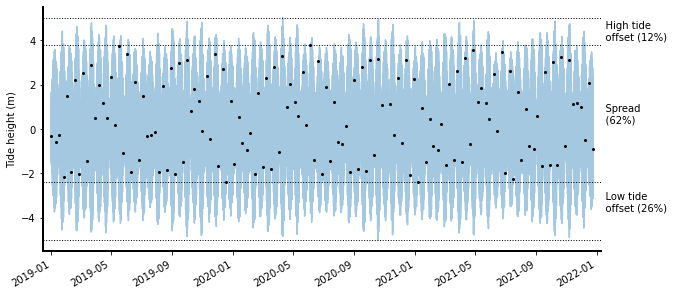

In [27]:
out_stats = tidal_stats(ds)

The function also outputs a `pandas.Series` object containing a set of statistics that compare the observed vs. full modelled tidal ranges.
These statistics include: 

* **tidepost_lat:** latitude used for modelling tide heights
* **tidepost_lon:** longitude used for modelling tide heights
* **observed_min_m:** minimum tide height observed by the satellite (in metre units)
* **all_min_m:** minimum tide height from full modelled tidal range (in metre units)
* **observed_max_m:** maximum tide height observed by the satellite (in metre units)
* **all_max_m:** maximum tide height from full modelled tidal range (in metre units)
* **observed_range_m:** tidal range observed by the satellite (in metre units)
* **all_range_m:** full modelled tidal range (in metre units)
* **spread_m:** proportion of the full modelled tidal range observed by the satellite (see [Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3))
* **low_tide_offset:** proportion of the lowest tides never observed by the satellite (see [Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3))
* **high_tide_offset:** proportion of the highest tides never observed by the satellite (see [Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3))

In [28]:
out_stats

tidepost_lat        -18.200
tidepost_lon        122.215
observed_mean_m       0.516
all_mean_m           -0.000
observed_min_m       -2.407
all_min_m            -5.018
observed_max_m        3.787
all_max_m             5.025
observed_range_m      6.194
all_range_m          10.044
spread                0.617
low_tide_offset       0.260
high_tide_offset      0.123
dtype: float64

---

## Additional information

**FES2014:** Tidal modelling is provided by the FES2014 global tidal model, implemented using functions from the [pyTMD Python package](https://pytmd.readthedocs.io/en/latest/getting_started/Citations.html). FES2014 was produced by NOVELTIS, LEGOS, CLS Space Oceanography Division and CNES. It is distributed by AVISO, with support from CNES (https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html).

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2022

**Compatible datacube version:** 

In [29]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)